In [1]:
%%time
%matplotlib inline

import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

import joblib
import seaborn as sns
from scipy.signal import savgol_filter
from scipy.linalg import sqrtm
from sklearn.utils import resample
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, IsolationForest
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, make_scorer, precision_score, recall_score, accuracy_score
from sklearn.cluster import DBSCAN
from sklearn.svm import SVC

import keras
import tensorflow as tf

from sklearn.utils import resample
from IPython.display import clear_output

from keras.models import Model, Sequential
from keras.layers import *
from keras.optimizers import Adam, SGD

import time
import warnings
warnings.simplefilter(action = 'ignore', category = FutureWarning)
warnings.simplefilter(action = 'ignore', category = Warning)

import sys
import shutil

sys.version
import session_info
session_info.show()

CPU times: total: 2.58 s
Wall time: 6.96 s


%%time
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
    if tf.test.is_gpu_available():
        print("GPU is available.")
        !nvidia-smi
    else:
        print("Training on CPU.")

print('Number of replicas:', strategy.num_replicas_in_sync)
#tf.config.run_functions_eagerly(True)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [3]:
%%time
ROOT_DIR = "./"
DATA_DIR = "%s/data" % ROOT_DIR
EVAL_DIR = "%s/evaluation" % ROOT_DIR
MODEL_DIR = "%s/models" % ROOT_DIR
WEIGHTS_DIR = "%s/weights" % ROOT_DIR
SAMPLES_DIR = "%s/samples" % ROOT_DIR
GENERATED_DIR = "%s/generated" % ROOT_DIR

#Create missing directories, if they don't exist
if not os.path.exists(DATA_DIR):
    # Create a new directory because it does not exist
    os.makedirs(DATA_DIR)
    print("The data directory is created!")
if not os.path.exists(EVAL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(EVAL_DIR)
    print("The evaluation directory is created!")
if not os.path.exists(MODEL_DIR):
    # Create a new directory because it does not exist
    os.makedirs(MODEL_DIR)
    print("The model directory is created!")
if not os.path.exists(WEIGHTS_DIR):
    # Create a new directory because it does not exist
    os.makedirs(WEIGHTS_DIR)
    print("The weights directory is created!")
if not os.path.exists(SAMPLES_DIR):
    # Create a new directory because it does not exist
    os.makedirs(SAMPLES_DIR)
    print("The samples directory is created!")
if not os.path.exists(GENERATED_DIR):
    # Create a new directory because it does not exist
    os.makedirs(GENERATED_DIR)
    print("The generated directory is created!")

CPU times: total: 0 ns
Wall time: 999 µs


In [4]:
def smooth_signal(row, window_length=5, polyorder=2):
    return savgol_filter(row, window_length=window_length, polyorder=polyorder)

def calculate_fid(df_real, df_generated):
    """
    Compute FID score between two pandas dataframes where:
    - Each row is a different signal
    - Each column is a data point of the signal

    Parameters:
        df_real (pd.DataFrame): DataFrame of real signals
        df_generated (pd.DataFrame): DataFrame of generated signals

    Returns:
        fid_score (float): Computed FID score
    """

    # Convert DataFrames to NumPy arrays
    real_data = df_real.to_numpy()
    gen_data = df_generated.to_numpy()

    # Compute mean and covariance matrices
    mu_real, sigma_real = np.mean(real_data, axis=0), np.cov(real_data, rowvar=False)
    mu_gen, sigma_gen = np.mean(gen_data, axis=0), np.cov(gen_data, rowvar=False)

    # Compute square root of product of covariances
    cov_sqrt, _ = sqrtm(sigma_real @ sigma_gen, disp=False)

    # Check for numerical issues (complex numbers)
    if np.iscomplexobj(cov_sqrt):
        cov_sqrt = cov_sqrt.real

    # Compute FID score
    fid_score = np.sum((mu_real - mu_gen) ** 2) + np.trace(sigma_real + sigma_gen - 2 * cov_sqrt)
    
    return fid_score

In [5]:
def train_model(model, X_train, y_train, cv_type, name, **cv_kwargs):
    """Trains a machine learning model using the provided training data and cross validation search type.
    The best model is saved to file with the given name. If that file already exists, this function simply loads it"""
    file_name = os.path.join(MODEL_DIR, f"{name}.pkl")
    
    if os.path.isfile(file_name):
        print("We already trained this model, loading it now")
        model = joblib.load(file_name)
    else:
        if cv_type == "grid":
            model = GridSearchCV(model, **cv_kwargs)
        else:
            model = RandomizedSearchCV(model, **cv_kwargs)
        
        model.fit(X_train, y_train)

        joblib.dump(model, file_name)
    
    print("Best Model Parameters")
    print(model.best_params_)
    
    return model

def make_confusion_matrix(model, X, y):
    """Display the confusion matrix of a model's predictions of given data. Also display Macro F1 Score."""
    
    yhat = model.predict(X)
    
    f1 = f1_score(y, yhat, average="macro")
    print(f"Macro F1 Score = {f1}")
    cm = confusion_matrix(y, yhat)
    
    cmn = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    cm = ConfusionMatrixDisplay(cmn)
    cm.plot()
    
def add_to_model_summary_df(summary_df, model, model_name, X_test, y_test):
    """Compiles the results of many machine learning models into a single dataframe for easy analysis"""
    if summary_df is None:
        summary_df = pd.DataFrame(columns=["Name", "Accuracy", "Precision", "Recall", "Macro F1", "Train Time"])
        
    y_test_pred = model.predict(X_test)
    
    model_summary_dict = {"Name": [model_name],
                          "Accuracy": [accuracy_score(y_test, y_test_pred)],
                          "Precision": [precision_score(y_test, y_test_pred, average="macro")],
                          "Recall": [recall_score(y_test, y_test_pred, average="macro")],
                          "Macro F1": [f1_score(y_test, y_test_pred, average="macro")],
                          "Train Time": [np.sum(model.cv_results_["mean_fit_time"])]}
    
    return pd.concat([summary_df, pd.DataFrame(model_summary_dict)], ignore_index=True)

# Loading the Data

In [6]:
%%time
train_file_path = '%s/mitbih_train.csv' % DATA_DIR
test_file_path = '%s/mitbih_test.csv' % DATA_DIR
column_names = [f"Point {i+1}" for i in range(187)] + ["label"]
df_train = pd.read_csv(train_file_path, names=column_names)
df_test = pd.read_csv(test_file_path, names=column_names)
df_train["label"] = df_train["label"].astype(int)
df_test["label"] = df_test["label"].astype(int)

CPU times: total: 2.31 s
Wall time: 3.23 s


In [7]:
load_file_path = '%s/' % GENERATED_DIR
df_generated = pd.read_csv(load_file_path+"20250201-150023_CGAN_generator_120000.csv", encoding='utf-8', index_col=0)
df_generated.columns = column_names

In [8]:
df_smooth = df_generated.drop(['label'], axis=1)
df_smooth = df_smooth.apply(smooth_signal, axis=1, result_type="expand")
df_smooth['label'] = df_generated['label']
df_smooth.columns = column_names

In [9]:
df_smooth

,Point 1,Point 2,Point 3,Point 4,Point 5,Point 6,Point 7,Point 8,Point 9,Point 10,...,Point 179,Point 180,Point 181,Point 182,Point 183,Point 184,Point 185,Point 186,Point 187,label
0,1.082148,0.657453,0.334052,0.042537,0.014229,0.036435,0.052783,0.050257,0.038223,0.033742,...,0.000670,0.000949,0.000670,-0.000167,0.000000,0.000000,0.000000,0.000000,0.000000,0
1,1.011094,0.681423,0.441266,0.228714,0.224997,0.241569,0.223903,0.250089,0.242029,0.249157,...,0.028501,0.027294,0.040106,0.024076,0.046135,0.035343,0.030885,0.023158,0.009357,1
2,0.150214,0.698483,0.883066,0.465711,0.352149,0.568734,0.717940,0.699323,0.577354,0.511526,...,0.003453,0.003523,0.003279,0.002631,0.002693,0.001402,0.001123,0.002149,0.004152,2
3,0.781643,0.768469,0.665437,0.400951,0.299511,0.284520,0.280020,0.215269,0.189394,0.141969,...,0.010156,-0.000847,0.054019,0.068591,0.060003,0.005390,0.013303,0.010876,0.007402,3
4,0.820223,0.548469,0.426757,0.525311,0.544174,0.596637,0.579520,0.593014,0.416040,0.286829,...,0.002860,0.003076,0.003013,0.001883,0.002330,0.002121,0.001619,0.001151,0.000579,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,0.884657,0.709391,0.541183,0.356320,0.213394,0.210286,0.239060,0.237411,0.174354,0.141814,...,0.033859,0.013821,0.071875,0.077046,0.088269,0.030274,0.038857,0.033051,0.021879,0
499996,0.458401,0.483102,0.430685,0.107335,0.207325,0.297875,0.239337,0.194694,0.253943,0.255397,...,0.170823,0.118140,0.174886,0.141443,0.166570,0.061567,0.056373,0.051701,0.059401,1
499997,0.845951,0.602434,0.447689,0.387566,0.385303,0.330509,0.304917,0.327331,0.322231,0.285871,...,0.043653,0.021535,0.073299,0.077039,0.095389,0.045046,0.038616,0.030027,0.019692,2
499998,0.986369,0.787686,0.603831,0.428994,0.261783,0.232640,0.227154,0.227483,0.182077,0.151020,...,0.009116,0.001515,0.016878,0.018439,0.019877,0.005672,0.012778,0.012199,0.008656,3


# Basic EDA

train_value_counts
test_value_counts
CPU times: total: 31.2 ms
Wall time: 34.1 ms


Text(0.5, 1.0, 'Test Data Label Distribution')

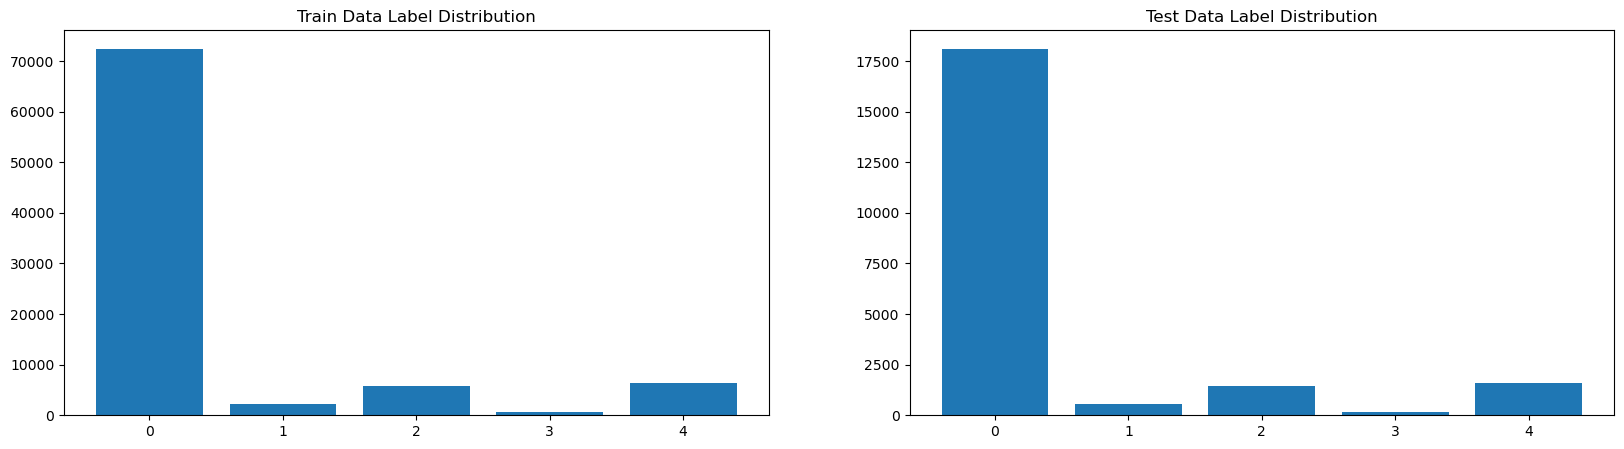

In [54]:
%%time
train_value_counts = df_train["label"].value_counts()
test_value_counts = df_test["label"].value_counts()
print("train_value_counts")
print("test_value_counts")
fig, axs = plt.subplots(1, 2, figsize=(20, 5))
axs[0].bar(train_value_counts.index, train_value_counts.values)
axs[0].set_title("Train Data Label Distribution")
axs[1].bar(test_value_counts.index, test_value_counts.values)
axs[1].set_title("Test Data Label Distribution")

CPU times: total: 859 ms
Wall time: 1.02 s


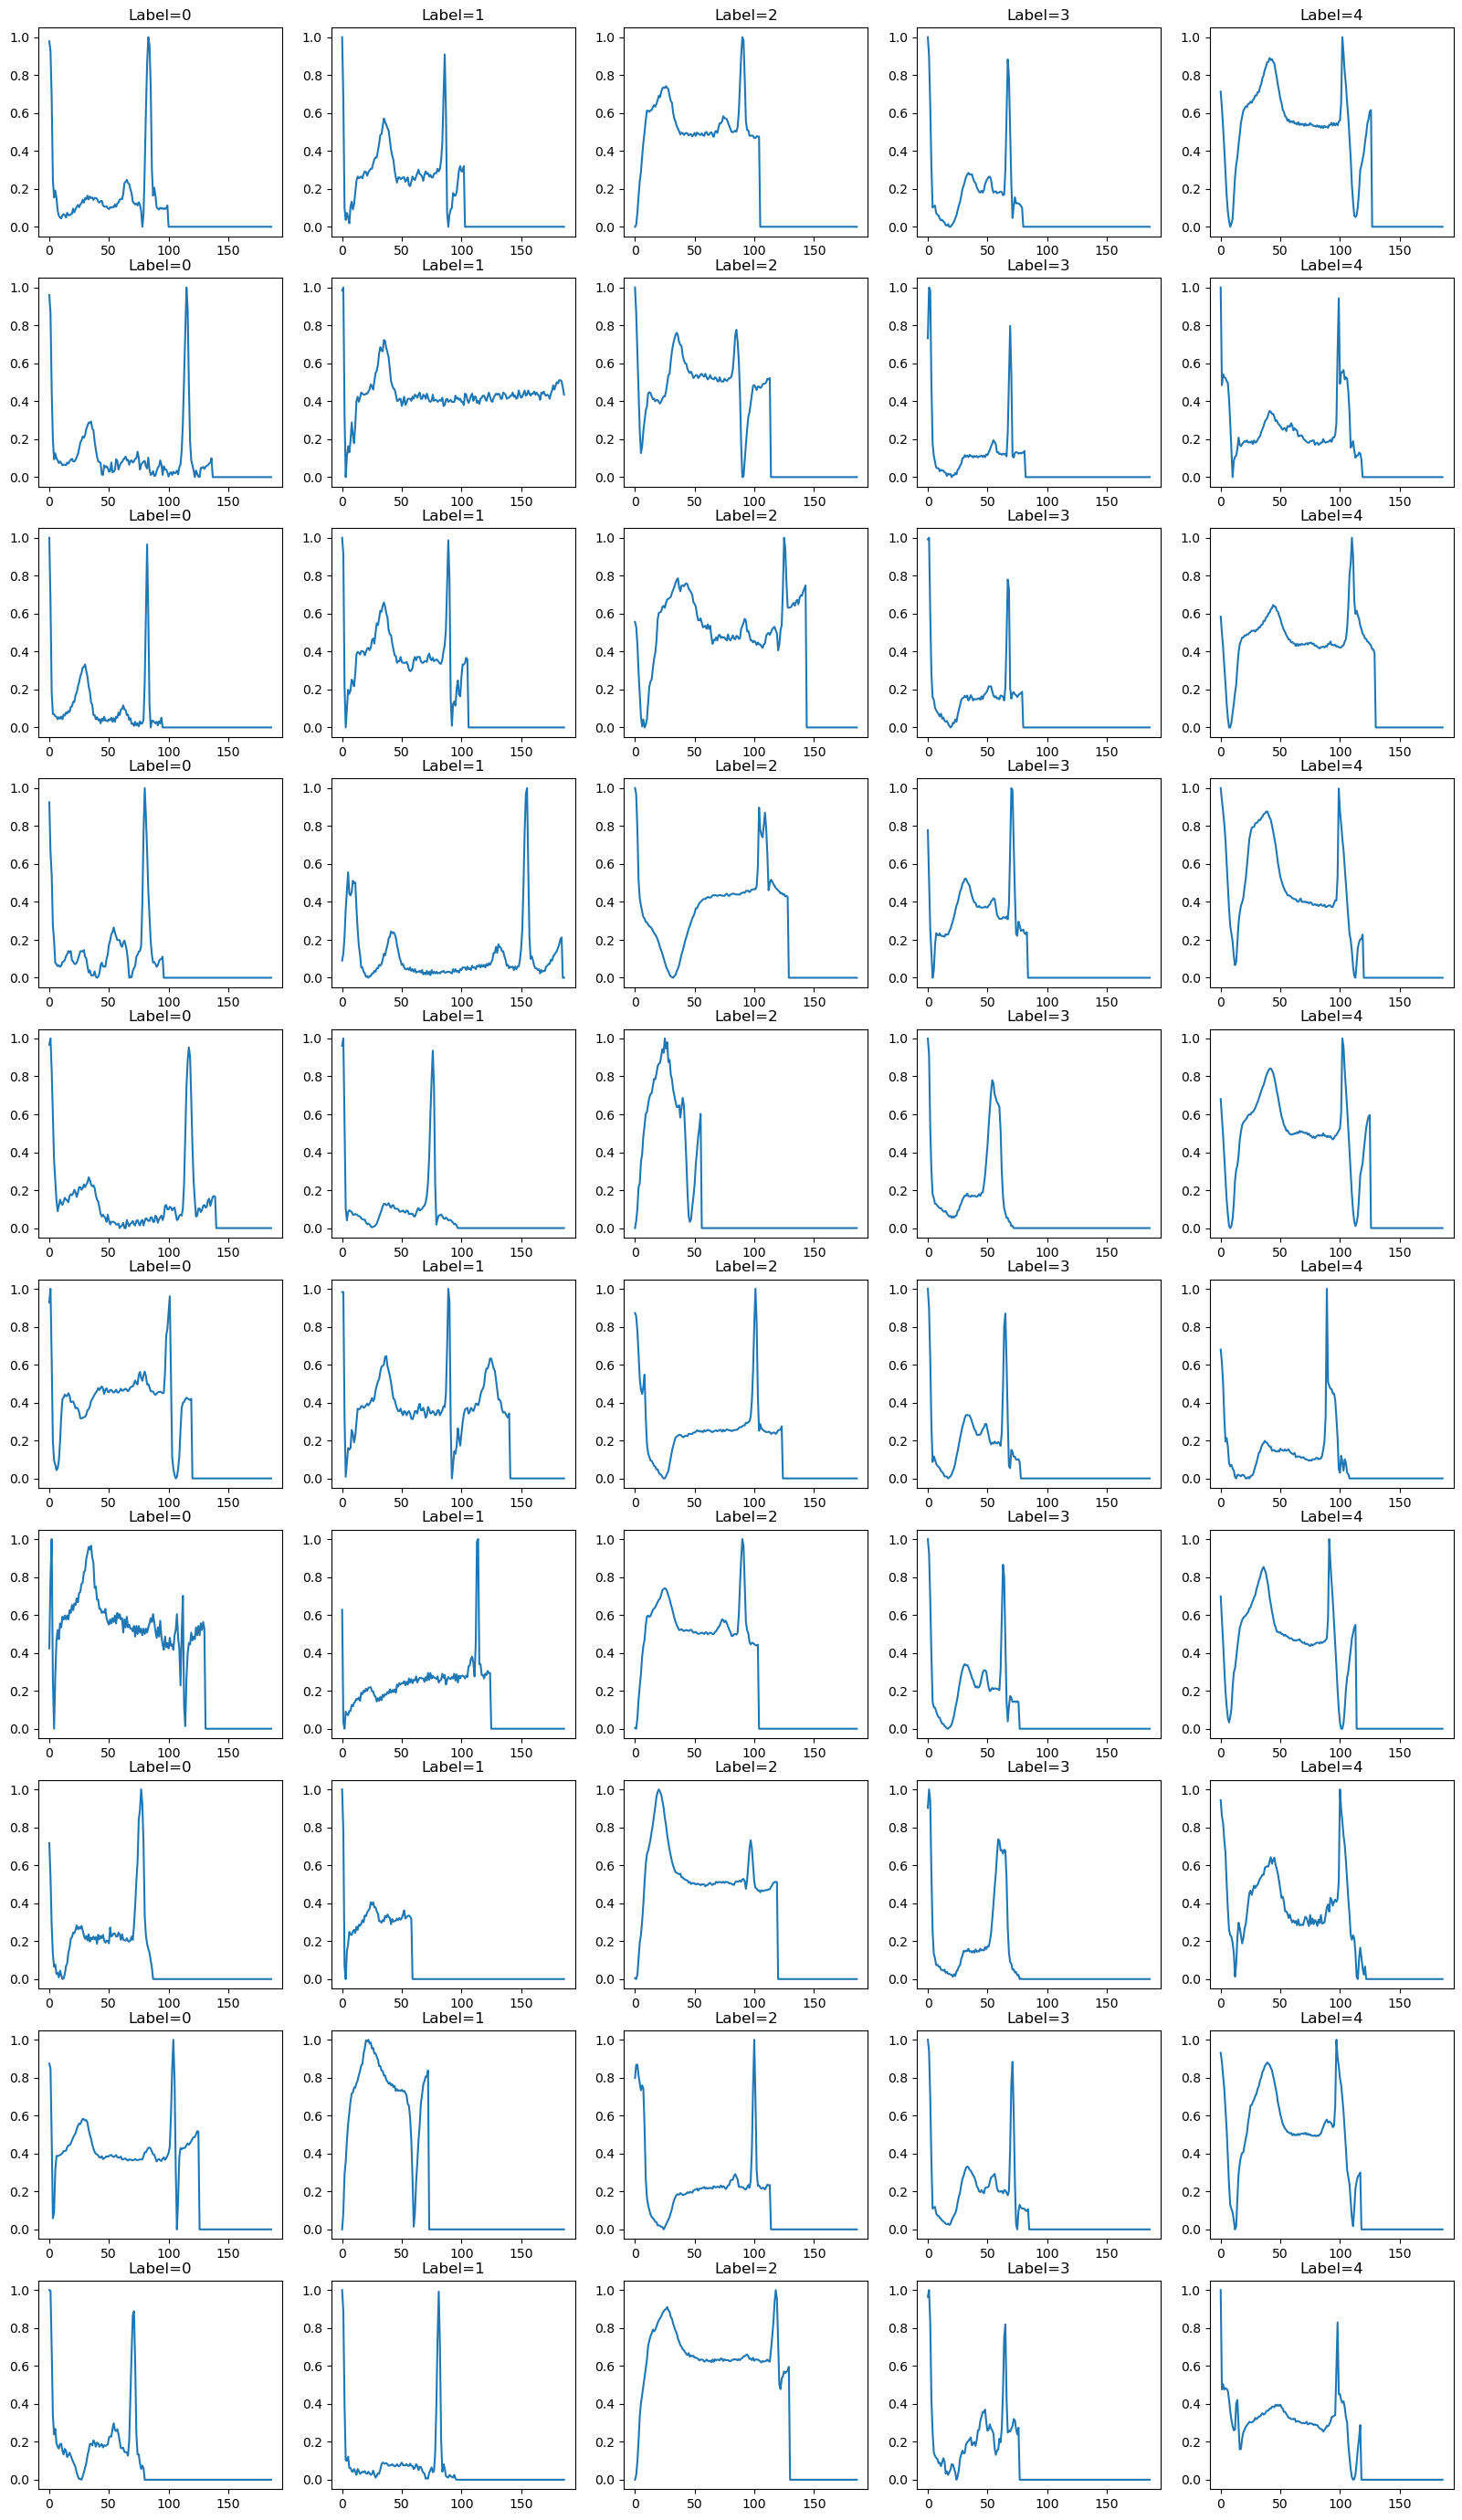

In [11]:
%%time
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_train[df_train["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")

CPU times: total: 1.55 s
Wall time: 2.87 s


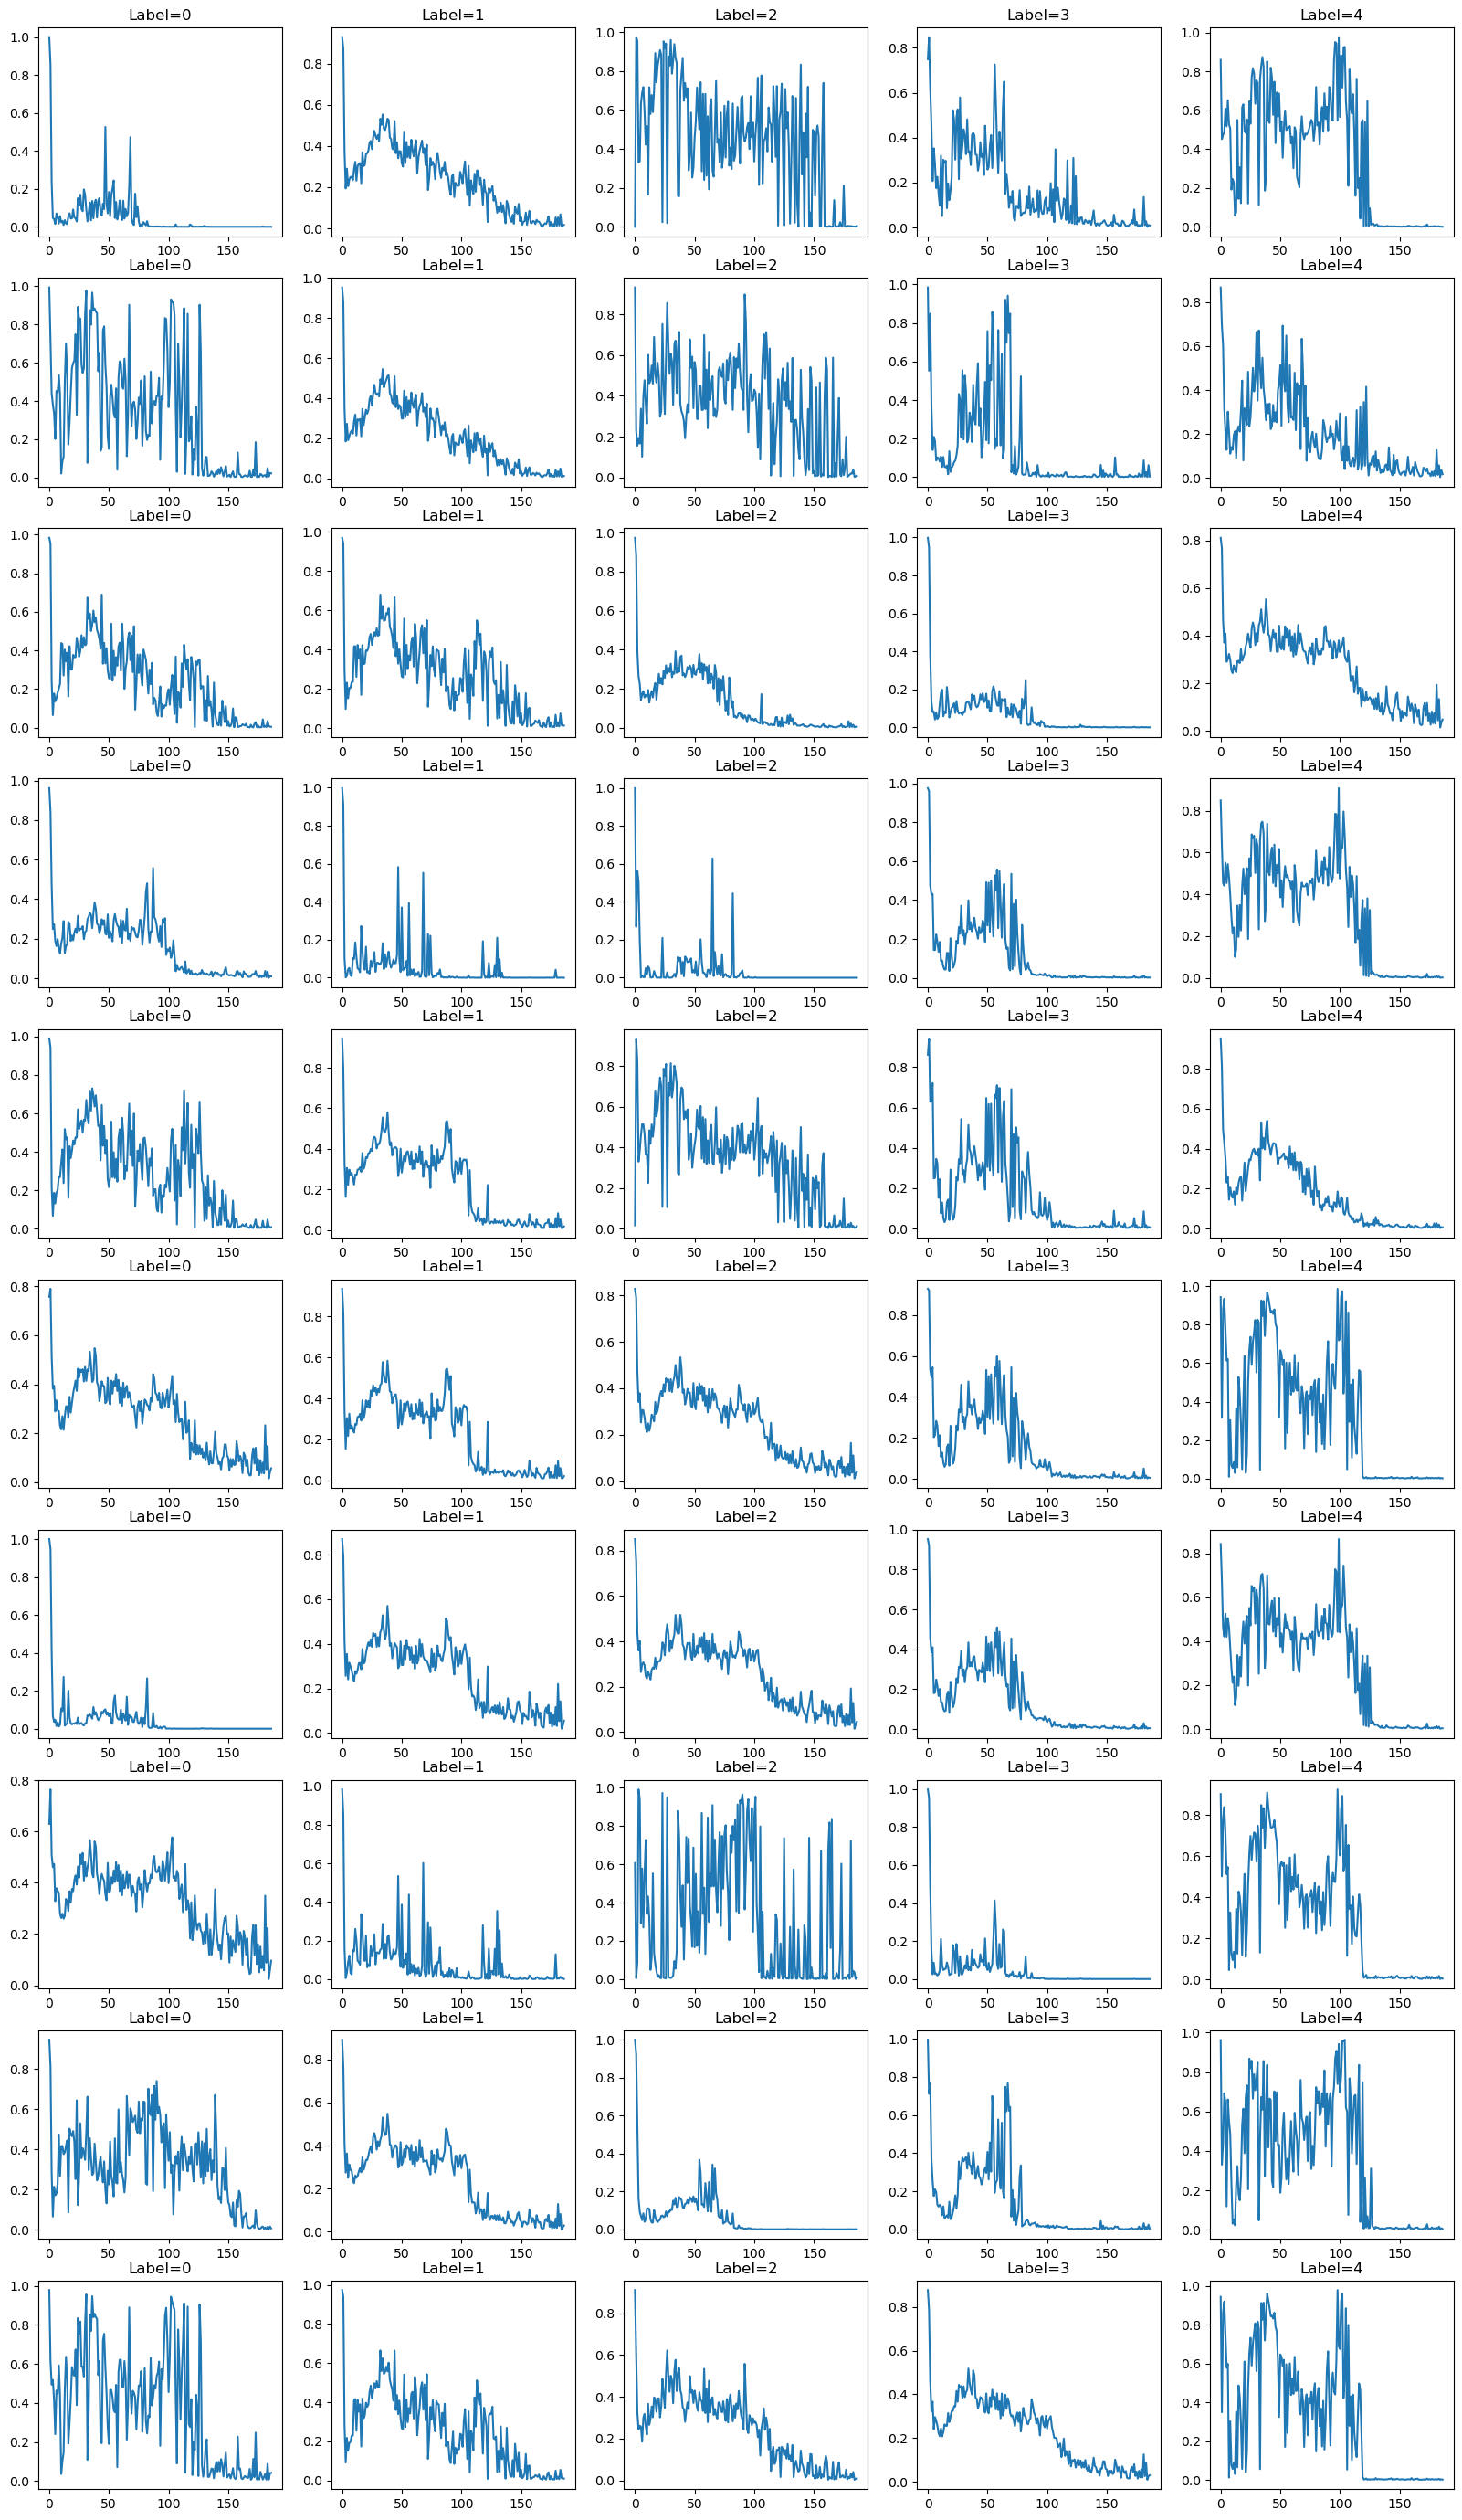

In [12]:
%%time
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_generated[df_generated["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")

CPU times: total: 2.81 s
Wall time: 3.77 s


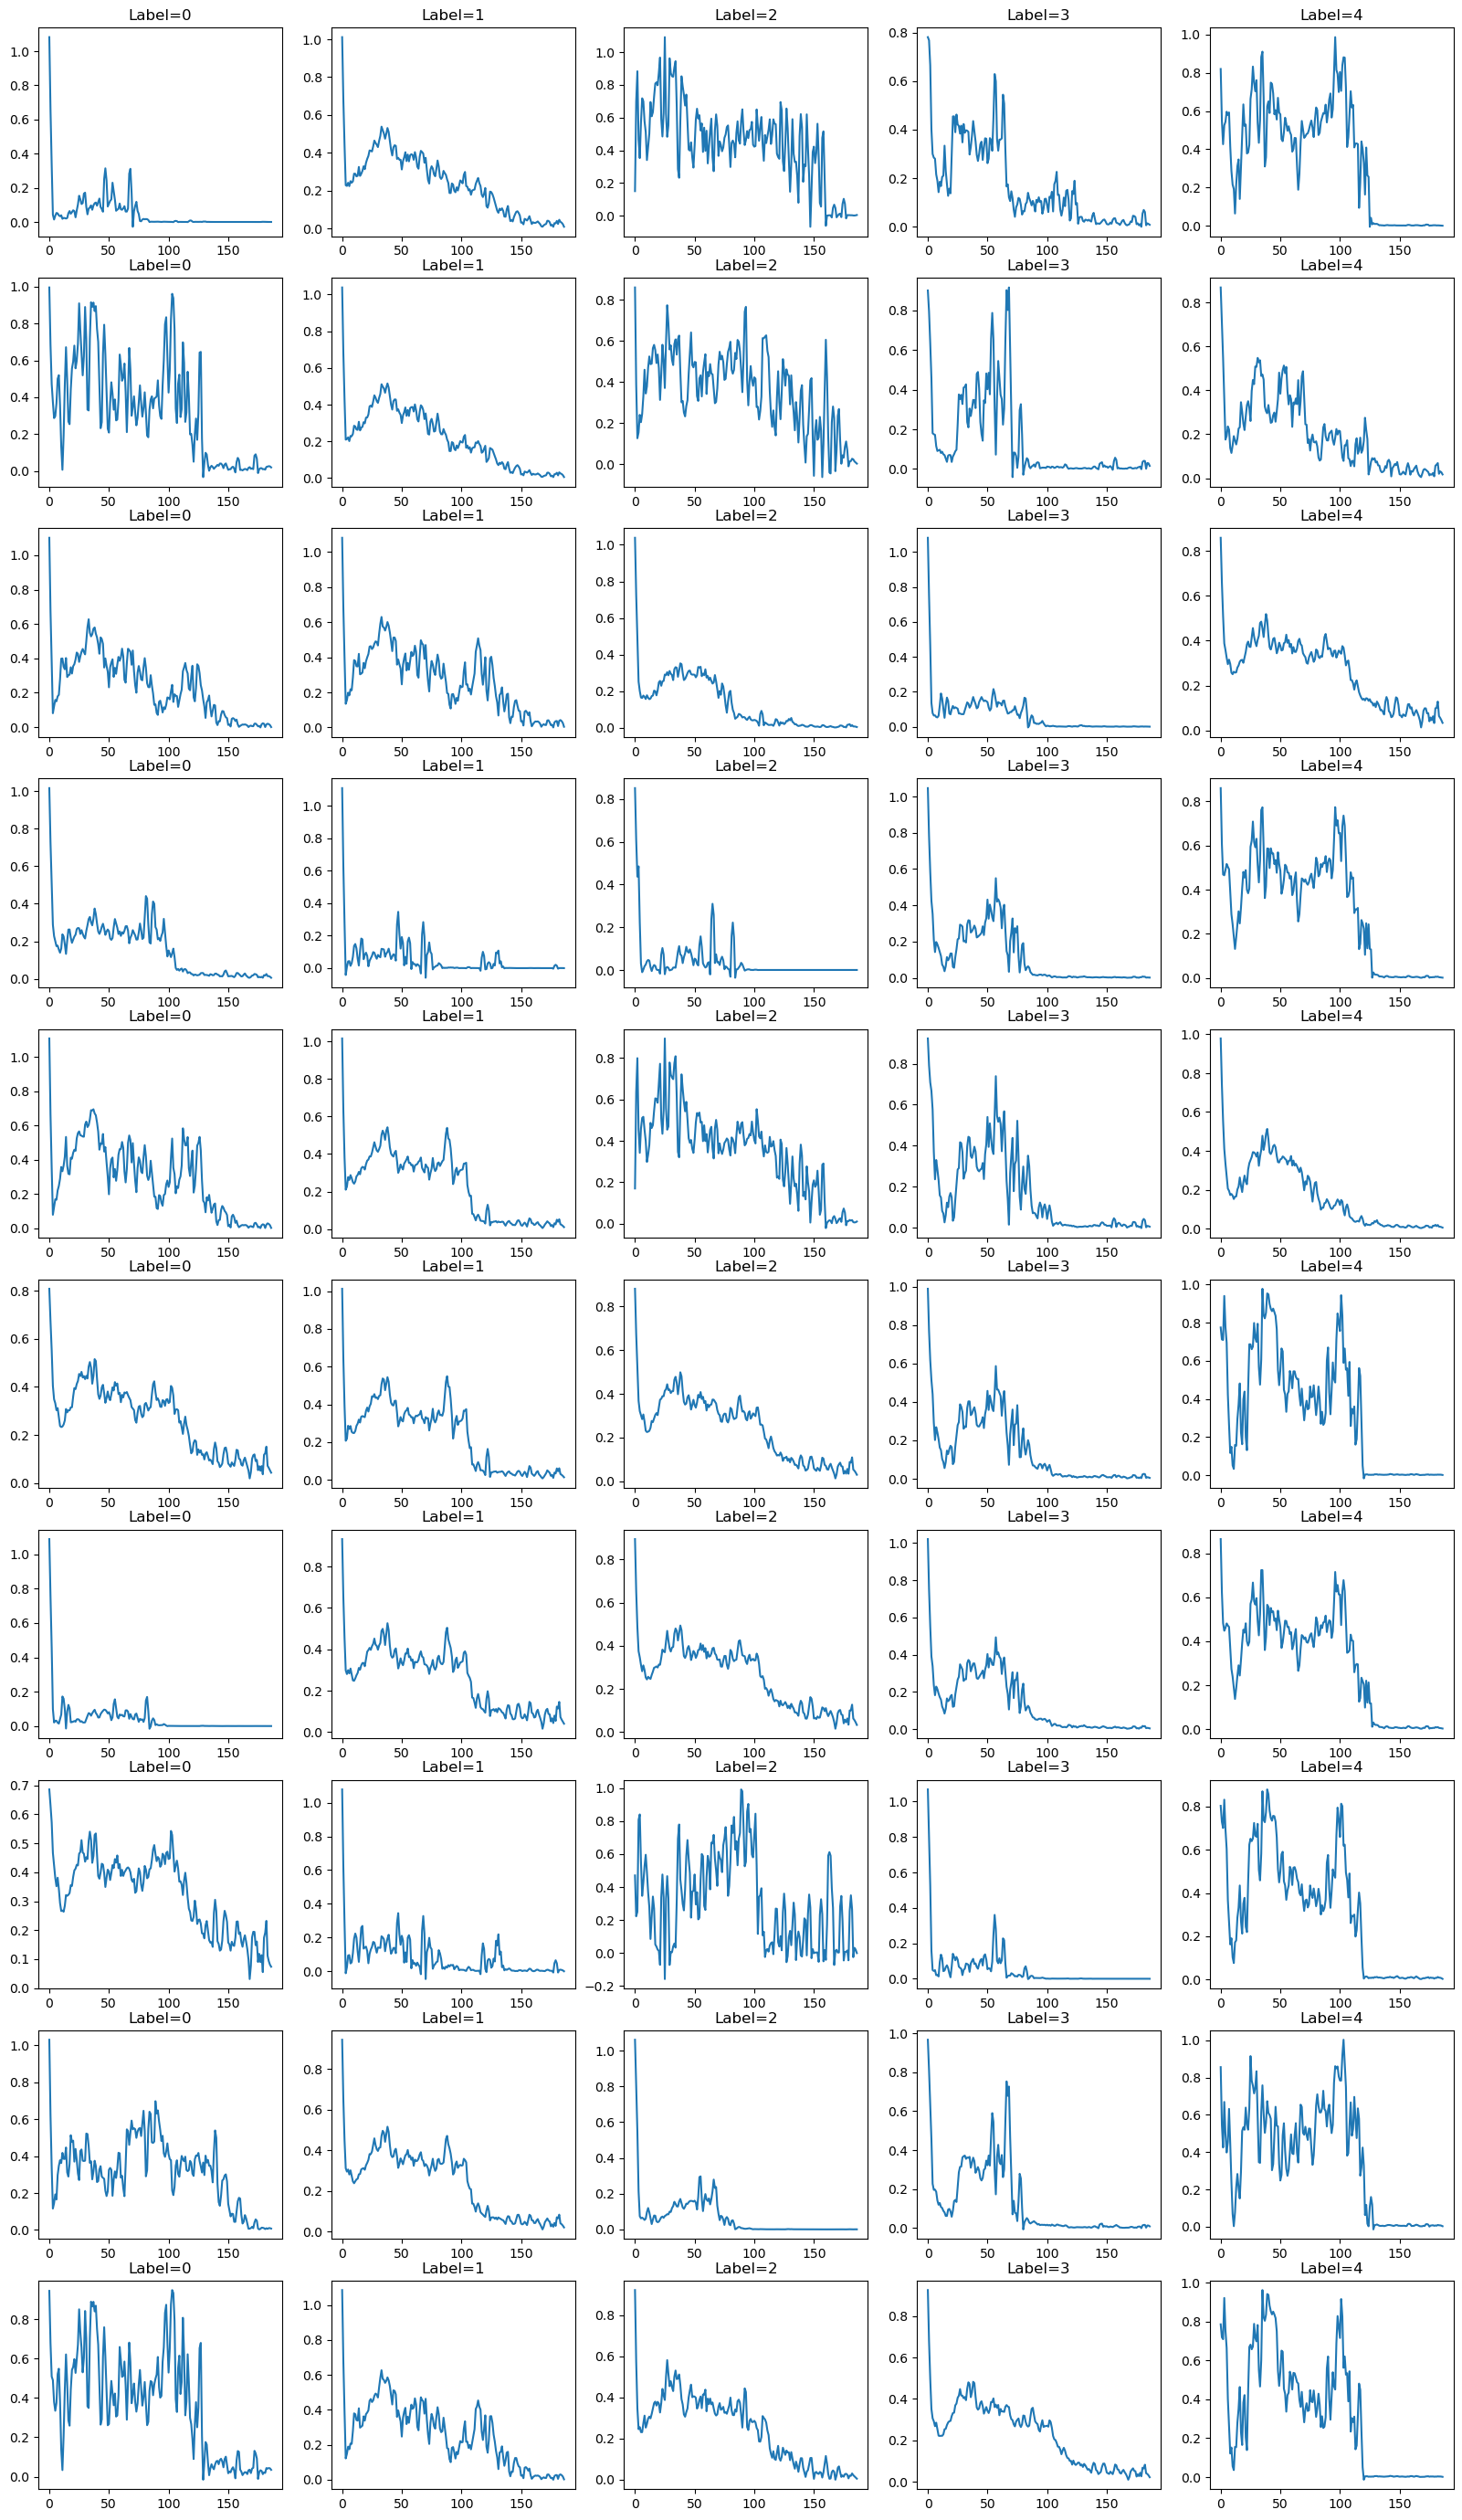

In [13]:
%%time
labels = [0, 1, 2, 3, 4]

n_to_view = 10
fig, axs = plt.subplots(n_to_view, 5, figsize=(20, 35))
for label in labels:
    label_df = df_smooth[df_smooth["label"] == label]
    for i in range(n_to_view):
        data = label_df.drop(['label'], axis=1).iloc[i].values
        axs[i, label].plot(range(len(data)), data)
        axs[i, label].set_title(f"Label={label}")

In [14]:
%%time
train_means = df_train.drop(['label'], axis=1).mean(axis=1)
train_stds = df_train.drop(['label'], axis=1).std(axis=1)
df_train["mean"] = train_means
df_train["std"] = train_stds

test_means = df_test.drop(['label'], axis=1).mean(axis=1)
test_stds = df_test.drop(['label'], axis=1).std(axis=1)
df_test["mean"] = test_means
df_test["std"] = test_stds

CPU times: total: 172 ms
Wall time: 187 ms


In [15]:
%%time
generated_means = df_generated.drop(['label'], axis=1).mean(axis=1)
generated_stds = df_generated.drop(['label'], axis=1).std(axis=1)
df_generated["mean"] = generated_means
df_generated["std"] = generated_stds

CPU times: total: 484 ms
Wall time: 639 ms


In [16]:
%%time
smooth_means = df_smooth.drop(['label'], axis=1).mean(axis=1)
smooth_stds = df_smooth.drop(['label'], axis=1).std(axis=1)
df_smooth["mean"] = generated_means
df_smooth["std"] = generated_stds

CPU times: total: 766 ms
Wall time: 872 ms


CPU times: total: 3.97 s
Wall time: 4.63 s


<Axes: >

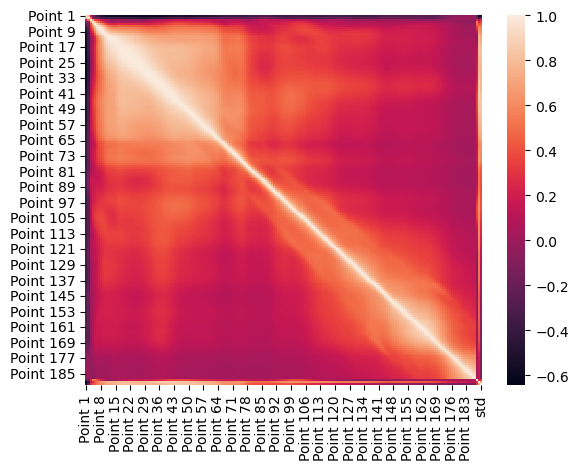

In [17]:
%%time
sns.heatmap(df_train.corr())

CPU times: total: 21.4 s
Wall time: 25.7 s


<Axes: >

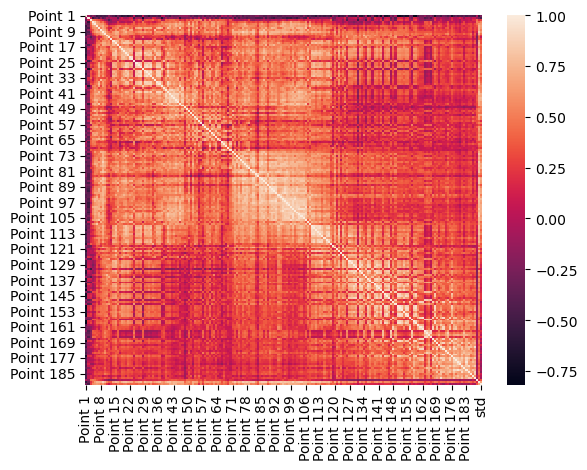

In [18]:
%%time
sns.heatmap(df_generated.corr())

CPU times: total: 21.8 s
Wall time: 26.1 s


<Axes: >

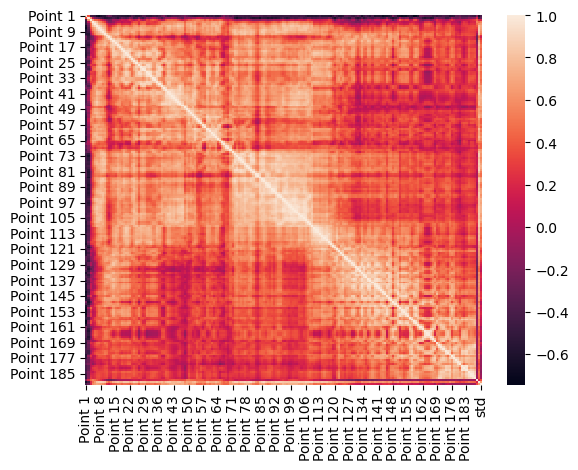

In [19]:
%%time
sns.heatmap(df_smooth.corr())

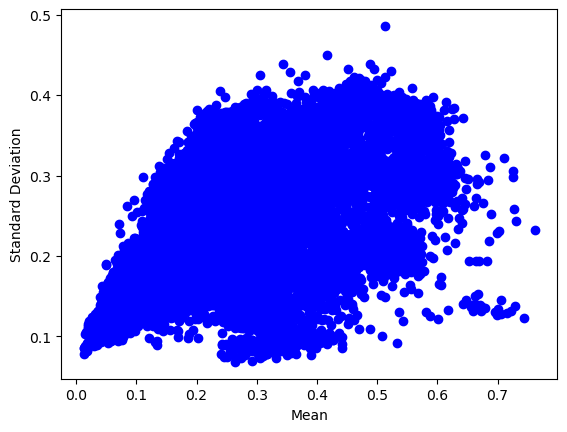

CPU times: total: 188 ms
Wall time: 271 ms


In [20]:
%%time
plt.scatter(df_train["mean"], df_train["std"], c="blue")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

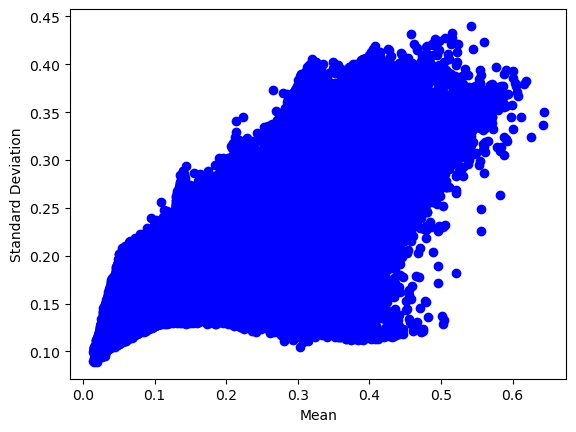

CPU times: total: 734 ms
Wall time: 1.05 s


In [21]:
%%time
plt.scatter(df_generated["mean"], df_generated["std"], c="blue")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

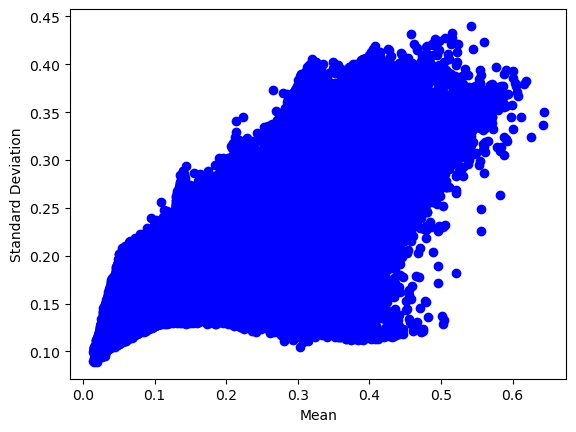

CPU times: total: 766 ms
Wall time: 1.07 s


In [22]:
%%time
plt.scatter(df_smooth["mean"], df_smooth["std"], c="blue")
plt.xlabel("Mean")
plt.ylabel("Standard Deviation")
plt.show()

In [25]:
fid = calculate_fid(df_train.drop(columns=["std", "mean", "label"]), df_test.drop(columns=["std", "mean", "label"]))
fid

0.0031876172476019305

In [29]:
fid = calculate_fid(df_train.drop(columns=["std", "mean", "label"]), df_generated.drop(columns=["std", "mean", "label"]))
fid

3.1628563046638387

In [31]:
fid = calculate_fid(df_train.drop(columns=["std", "mean", "label"]), df_smooth.drop(columns=["std", "mean", "label"]))
fid

2.4246684532721985

# Data Sampling

In [33]:
%%time
X_train = df_train.drop(['label'], axis=1).values
X_test = df_test.drop(['label'], axis=1).values
y_train = df_train["label"].values
y_test = df_test["label"].values

CPU times: total: 46.9 ms
Wall time: 51.6 ms


## Downsampled set of real data

In [36]:
%%time
df_0=(df_train[df_train['label']==0]).sample(n=641,random_state=42)
df_1=(df_train[df_train['label']==1]).sample(n=641,random_state=42)
df_2=(df_train[df_train['label']==2]).sample(n=641,random_state=42)
df_3=(df_train[df_train['label']==3]).sample(n=641,random_state=42)
df_4=(df_train[df_train['label']==4]).sample(n=641,random_state=42)

df_train_downsampled=pd.concat([df_0,df_1,df_2,df_3,df_4])

CPU times: total: 46.9 ms
Wall time: 61.7 ms


In [38]:
%%time
train_downsampled_value_counts = df_train_downsampled["label"].value_counts()
train_downsampled_value_counts

CPU times: total: 0 ns
Wall time: 1.01 ms


label
0    641
1    641
2    641
3    641
4    641
Name: count, dtype: int64

In [40]:
%%time
X_train_downsampled = df_train_downsampled.drop(['label'], axis=1).values
y_train_downsampled = df_train_downsampled["label"].values

CPU times: total: 15.6 ms
Wall time: 2.6 ms


## Upsampled set of real data

In [43]:
%%time
df_0=df_train[df_train['label']==0]
df_1=df_train[df_train['label']==1]
df_2=df_train[df_train['label']==2]
df_3=df_train[df_train['label']==3]
df_4=df_train[df_train['label']==4]

df_1_upsample=resample(df_1,replace=True,n_samples=72471,random_state=123)
df_2_upsample=resample(df_2,replace=True,n_samples=72471,random_state=124)
df_3_upsample=resample(df_3,replace=True,n_samples=72471,random_state=125)
df_4_upsample=resample(df_4,replace=True,n_samples=72471,random_state=126)

df_train_upsampled=pd.concat([df_0,df_1_upsample,df_2_upsample,df_3_upsample,df_4_upsample])

CPU times: total: 203 ms
Wall time: 289 ms


In [45]:
%%time
train_upsampled_value_counts = df_train_upsampled["label"].value_counts()
train_upsampled_value_counts

CPU times: total: 0 ns
Wall time: 1.51 ms


label
0    72471
1    72471
2    72471
3    72471
4    72471
Name: count, dtype: int64

In [47]:
%%time
X_train_upsampled = df_train_upsampled.drop(['label'], axis=1).values
y_train_upsampled = df_train_upsampled["label"].values

CPU times: total: 156 ms
Wall time: 139 ms


## Padded with generated data

In [50]:
%%time
df_generated_1 = df_generated[df_generated['label']==1]
df_generated_2 = df_generated[df_generated['label']==2]
df_generated_3 = df_generated[df_generated['label']==3]
df_generated_4 = df_generated[df_generated['label']==4]

CPU times: total: 219 ms
Wall time: 242 ms


In [56]:
%%time
df_1_pad = df_generated_1.sample(n=train_value_counts[0]-train_value_counts[1],random_state=42)
df_2_pad = df_generated_2.sample(n=train_value_counts[0]-train_value_counts[2],random_state=42)
df_3_pad = df_generated_3.sample(n=train_value_counts[0]-train_value_counts[3],random_state=42)
df_4_pad = df_generated_4.sample(n=train_value_counts[0]-train_value_counts[4],random_state=42)

df_train_padded=pd.concat([df_train,df_1_pad,df_2_pad,df_3_pad,df_4_pad])
df_train_padded
train_padded_value_counts = df_train_padded["label"].value_counts()
train_padded_value_counts

CPU times: total: 391 ms
Wall time: 470 ms


label
0    72471
1    72471
2    72471
3    72471
4    72471
Name: count, dtype: int64

In [58]:
%%time
X_train_padded = df_train_padded.drop(['label'], axis=1).values
y_train_padded = df_train_padded["label"].values

CPU times: total: 109 ms
Wall time: 137 ms


## Padded with Smoothened generated data

In [61]:
%%time
df_smooth_1 = df_smooth[df_smooth['label']==1]
df_smooth_2 = df_smooth[df_smooth['label']==2]
df_smooth_3 = df_smooth[df_smooth['label']==3]
df_smooth_4 = df_smooth[df_smooth['label']==4]

CPU times: total: 125 ms
Wall time: 141 ms


In [63]:
%%time
df_1_pad = df_smooth_1.sample(n=train_value_counts[0]-train_value_counts[1],random_state=42)
df_2_pad = df_smooth_2.sample(n=train_value_counts[0]-train_value_counts[2],random_state=42)
df_3_pad = df_smooth_3.sample(n=train_value_counts[0]-train_value_counts[3],random_state=42)
df_4_pad = df_smooth_4.sample(n=train_value_counts[0]-train_value_counts[4],random_state=42)

df_train_smooth_padded=pd.concat([df_train,df_1_pad,df_2_pad,df_3_pad,df_4_pad])
df_train_smooth_padded
train_smooth_padded_value_counts = df_train_smooth_padded["label"].value_counts()
train_smooth_padded_value_counts

CPU times: total: 297 ms
Wall time: 345 ms


label
0    72471
1    72471
2    72471
3    72471
4    72471
Name: count, dtype: int64

In [65]:
%%time
X_train_smooth_padded = df_train_smooth_padded.drop(['label'], axis=1).values
y_train_smooth_padded = df_train_smooth_padded["label"].values

CPU times: total: 125 ms
Wall time: 139 ms


## Purely generated data

In [68]:
%%time
train_generated_value_counts = df_generated["label"].value_counts()
train_generated_value_counts

CPU times: total: 0 ns
Wall time: 3 ms


label
0    100000
1    100000
2    100000
3    100000
4    100000
Name: count, dtype: int64

In [72]:
%%time
X_train_generated = df_generated.drop(['label'], axis=1).values
y_train_generated = df_generated["label"].values

CPU times: total: 125 ms
Wall time: 191 ms


## Purely smoothened generated data

In [74]:
%%time
train_smooth_value_counts = df_smooth["label"].value_counts()
train_smooth_value_counts

CPU times: total: 0 ns
Wall time: 2.88 ms


label
0    100000
1    100000
2    100000
3    100000
4    100000
Name: count, dtype: int64

In [76]:
%%time
X_train_smooth = df_smooth.drop(['label'], axis=1).values
y_train_smooth = df_smooth["label"].values

CPU times: total: 625 ms
Wall time: 719 ms


# Building the Models
## KNN

We already trained this model, loading it now
Best Model Parameters
{'n_neighbors': 1}
Macro F1 Score = 0.5874665089926493
CPU times: total: 12.8 s
Wall time: 2.21 s


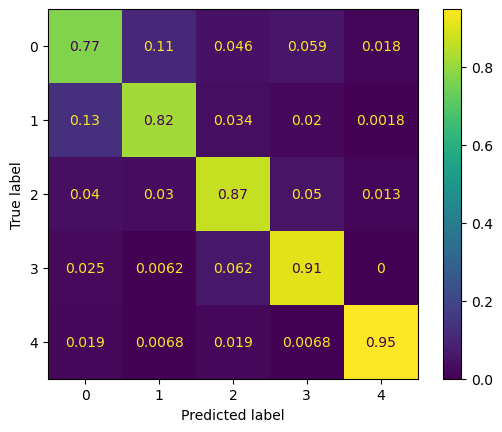

In [79]:
%%time
knn_parameters = dict(n_neighbors=[i for i in range(1, 10)])
scorer = make_scorer(f1_score, average="macro")
knn_downsampled = train_model(KNeighborsClassifier(),
                       X_train_downsampled, y_train_downsampled, "grid", "knn_downsampled",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(None, knn_downsampled, "knn_downsampled", X_test, y_test)
make_confusion_matrix(knn_downsampled, X_test, y_test)

We already trained this model, loading it now
Best Model Parameters
{'n_neighbors': 3}
Macro F1 Score = 0.8798956759210885
CPU times: total: 2min 10s
Wall time: 11.7 s


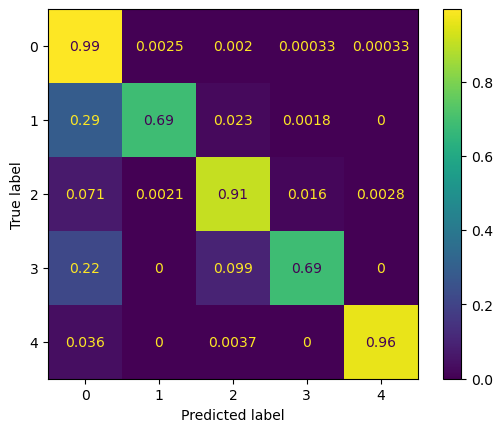

In [80]:
%%time
knn_full = train_model(KNeighborsClassifier(),
                       X_train, y_train, "grid", "knn_full",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_full, "knn_full", X_test, y_test)
make_confusion_matrix(knn_full, X_test, y_test)

We already trained this model, loading it now
Best Model Parameters
{'n_neighbors': 1}
Macro F1 Score = 0.8832261519485541
CPU times: total: 8min 30s
Wall time: 44 s


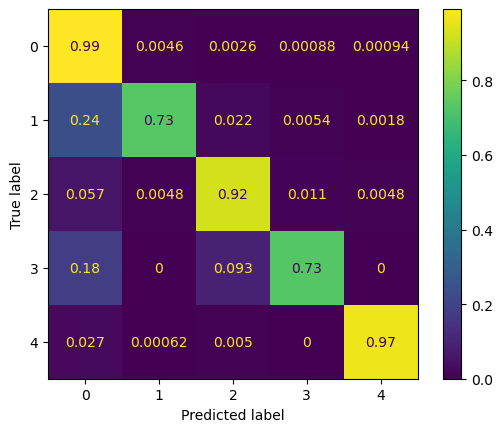

In [82]:
%%time
knn_upsampled = train_model(KNeighborsClassifier(),
                       X_train_upsampled, y_train_upsampled, "grid", "knn_upsampled",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_upsampled, "knn_upsampled", X_test, y_test)
make_confusion_matrix(knn_upsampled, X_test, y_test)

In [ ]:
%%time
knn_padded = train_model(KNeighborsClassifier(),
                       X_train_padded, y_train_padded, "grid", "knn_padded",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_padded, "knn_padded", X_test, y_test)
make_confusion_matrix(knn_padded, X_test, y_test)

In [ ]:
%%time
knn_smooth_padded = train_model(KNeighborsClassifier(),
                       X_train_smooth_padded, y_train_smooth_padded, "grid", "knn_smooth_padded",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_smooth_padded, "knn_smooth_padded", X_test, y_test)
make_confusion_matrix(knn_smooth_padded, X_test, y_test)

In [ ]:
%%time
knn_generated = train_model(KNeighborsClassifier(),
                       X_train_generated, y_train_generated, "grid", "knn_generated",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_generated, "knn_generated", X_test, y_test)
make_confusion_matrix(knn_generated, X_test, y_test)

In [ ]:
%%time
knn_smooth = train_model(KNeighborsClassifier(),
                       X_train_smooth, y_train_smooth, "grid", "knn_smooth",
                       param_grid=knn_parameters, scoring=scorer)

model_summary_df = add_to_model_summary_df(model_summary_df, knn_smooth, "knn_smooth", X_test, y_test)
make_confusion_matrix(knn_smooth, X_test, y_test)

In [ ]:
%%time
model_summary_df

## Random Forest

%%time
rf_parameters = dict(n_estimators = [10*i for i in range(1, 11)],
                     max_depth = [2**i for i in range(11)]+[None],
                     min_samples_split = [i+1 for i in range(1, 10)],
                     min_samples_leaf = [i for i in range(1, 10)])

%%time
rf_downsampled = train_model(RandomForestClassifier(random_state=42),
                      X_train_downsampled, y_train_downsampled, "random", "rf_downsampled",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_downsampled, "rf_downsampled", X_test, y_test)
make_confusion_matrix(rf_downsampled, X_test, y_test)

%%time
rf_full = train_model(RandomForestClassifier(random_state=42),
                      X_train, y_train, "random", "rf_full",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_full, "rf_full", X_test, y_test)
make_confusion_matrix(rf_full, X_test, y_test)

%%time
rf_upsampled = train_model(RandomForestClassifier(random_state=42),
                      X_train_upsampled, y_train_upsampled, "random", "rf_upsampled",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_upsampled, "rf_upsampled", X_test, y_test)
make_confusion_matrix(rf_upsampled, X_test, y_test)

%%time
rf_padded = train_model(RandomForestClassifier(random_state=42),
                      X_train_padded, y_train_padded, "random", "rf_padded",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_padded, "rf_padded", X_test, y_test)
make_confusion_matrix(rf_padded, X_test, y_test)

%%time
rf_generated = train_model(RandomForestClassifier(random_state=42),
                      X_train_generated, y_train_generated, "random", "rf_generated",
                      param_distributions=rf_parameters, n_jobs=8, scoring=scorer, verbose=1, n_iter=200, random_state=42)

model_summary_df = add_to_model_summary_df(model_summary_df, rf_generated, "rf_generated", X_test, y_test)
make_confusion_matrix(rf_generated, X_test, y_test)

%%time
model_summary_df